# Guardlytics: A Data-Driven Security Operations Project

## Introduction

This project presents a comprehensive analysis of guard operations and security performance across multiple sites using detailed patrol and scheduling datasets. The goal is to uncover actionable insights that can help improve guard scheduling, patrol coverage, response times, and incident management within a private security firm.

Through data wrangling, time-series analysis, and advanced visualization techniques in Python, the project explores patterns in attendance, shift punctuality, patrol completeness, QR location scans, and incident response. The analysis helps highlight site-specific challenges, guard performance variations, and systemic inefficiencies, especially around overtime and response to critical security incidents.

### Objectives

#### 1. Monitor Guard Attendance and Punctuality

   Identify guards frequently late across morning, afternoon, and night shifts.
   Highlight top guards who frequently cover for others to evaluate team reliability.

#### 2. Evaluate Patrol Effectiveness

   Analyze completion rates of scheduled patrols.
   Identify guards and locations with high non-completion rates.
   Examine patterns in QR code scans to assess area coverage.

#### 3. Assess Incident Response Efficiency

   Compare response times across guards, shifts, and incident types.
   Identify delays and their contributing factors (e.g., shift timing, location).

#### 4. Understand Incident Trends

   Categorize incidents by type, shift, and location.
   Pinpoint high-risk areas and shifts with elevated incident counts.

#### 5. Optimize Shift Allocation and Overtime Usage

   Evaluate overtime hours across shifts to uncover potential understaffing.
   Support data-driven scheduling decisions.

#### 6. Inform Site-Level Decision Making

   Highlight sites with the most patrols, incidents, and resource utilization.
   Recommend resource reallocation or increased supervision where needed.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_schedule = pd.read_csv('/Users/andrew/Downloads/guard_shift_schedule_with_weekly_hours.csv')

In [3]:
df_schedule['Clock_In'] = pd.to_datetime(df_schedule['Clock_In'])
df_schedule['Clock_Out'] = pd.to_datetime(df_schedule['Clock_Out'])

In [4]:
df_schedule.head()

,Guard_ID,Date,Week,Regular_Shift,Actual_Shift,Is_Covering,Site,Clock_In,Clock_Out,Hours_Worked,Weekly_Hours,Over_40_Hours
0,1000,2024-01-01,1,Night,Night,False,Oakland CA,2024-01-01 22:26:00,2024-01-02 06:44:00,8.30,49.1,True
1,1000,2024-01-03,1,Night,Night,False,Oakland CA,2024-01-03 22:32:00,2024-01-04 06:39:00,8.12,49.1,True
2,1000,2024-01-04,1,Night,Night,False,Oakland CA,2024-01-04 22:30:00,2024-01-05 06:32:00,8.03,49.1,True
3,1000,2024-01-05,1,Night,Morning,True,Oakland CA,2024-01-05 06:32:00,2024-01-05 14:45:00,8.22,49.1,True
4,1000,2024-01-06,1,Night,Night,False,Oakland CA,2024-01-06 22:26:00,2024-01-07 06:43:00,8.28,49.1,True


In [5]:
locs = list(df_schedule['Site'].unique())
def guards_by_site(site):
    locs = list(df_schedule['Site'].unique())
    for loc in locs:
        return (df_schedule[df_schedule['Site'] == loc]['Guard_ID']).nunique()

In [6]:
for loc in locs:
    guards_by_site(loc)

In [7]:
def top_n_guards_covering(n):    
    guards_covering = (df_schedule
     .groupby('Guard_ID')['Is_Covering']
     .sum()
     .reset_index(name='# covering')
     .sort_values(by='# covering', ascending=False)
    )

    top_5_guards_covering = guards_covering['# covering'].nlargest(n).min()

    return guards_covering[guards_covering['# covering'] >= top_5_guards_covering]

In [8]:
# Top 5 guards that cover other guards' shifts
top_n_guards_covering(5)

,Guard_ID,# covering
26,1026,31
57,1057,31
19,1019,29
88,1088,28
14,1014,27
24,1024,27
79,1079,27


In [9]:
df_schedule_attendance = df_schedule.copy()
    
df_schedule_attendance['Clock_In_Hour'] = df_schedule_attendance['Clock_In'].dt.hour
df_schedule_attendance['Clock_In_Minute'] = df_schedule_attendance['Clock_In'].dt.minute   

In [10]:
def top_n_latest_guards(shift,on_time_hour,on_time_minute,late_minute, n):
    '''
    Returns attendance dataframe for a shift
    
    Parameters:
    shift :          String showing the shift you want to look at
    on_time_hour :   Int showing the hour during which the shift starts
    on_time_minute : Int showing the minute at whcih the shift starts
    late_minute:     Int showing minute after which guard is late
    n:               Int showing nth highest value
    
    Returns:
    A pd dataframe with the n latest guards and how many times they were late
    '''
    
    attendance = df_schedule_attendance[
        (df_schedule_attendance['Clock_In_Hour'] >= on_time_hour) & 
        (df_schedule_attendance['Clock_In_Minute'] >= on_time_minute) &
        (df_schedule_attendance['Actual_Shift'] == shift)
    ][['Guard_ID','Clock_In','Clock_In_Hour','Clock_In_Minute']]
    
    # Scheduled attendances where the guard was late
    late = attendance[
        (attendance['Clock_In_Hour'] > on_time_hour) | 
        (attendance['Clock_In_Minute'] >= late_minute)
    ]
    
    # Number of times guards were late
    times_late = (late
                  .groupby('Guard_ID')['Clock_In_Hour']
                  .count()
                  .reset_index(name='# of times late')
                  .sort_values(by='# of times late', ascending=False)
                 )
    # The nth highest value
    top_n_cutoff = times_late['# of times late'].nlargest(n).min()
    
    # Top n guards that are late the most times during the morning shift
    latest_guards = times_late[times_late['# of times late'] >= top_n_cutoff]
    
    return latest_guards

In [11]:
# Latest guards in the morning shift
morning_shift_latest_guards = top_n_latest_guards('Morning', 6, 30, 35, 5)
morning_shift_latest_guards

,Guard_ID,# of times late
0,1001,17
17,1020,14
50,1068,11
31,1042,11
64,1092,11
53,1072,11


Guard 1001 was late 17 times
Several others (1020, 1068, 1042) had 11–14 late arrivals

In [12]:
# Latest guards in the afternoon shift
afternoon_shift_latest_guards = top_n_latest_guards('Afternoon', 14, 30, 35, 5)
afternoon_shift_latest_guards

,Guard_ID,# of times late
56,1085,13
19,1034,12
52,1079,12
40,1060,12
33,1051,10
49,1075,10


Guard 1085 was late 13 times. Others like 1034, 1079, 1060 were late 12 times.

In [13]:
# Latest guards in the night shift
night_shift_latest_guards = top_n_latest_guards('Night', 22, 30, 35, 5)
night_shift_latest_guards

,Guard_ID,# of times late
61,1091,16
56,1084,13
14,1021,13
60,1090,10
47,1066,9
6,1010,9
36,1053,9
8,1012,9
59,1088,9


Guard 1091 was late 16 times. 1084, 1021 were late 13 times while 1090 was late 12 times.

In [14]:
df_patrols = pd.read_csv('/Users/andrew/Downloads/synced_guard_patrols.csv')

In [15]:
df_patrols.head()

,Timestamp,Site,Guard_ID,Shift,Interior_Exterior,Incident_Type,Response_Time_Minutes,Patrol_Completed,QR_Scans,QR_Code_Locations_Scanned,Overtime_Hours,Week
0,2024-01-01 22:13:37.155536510,Oakland CA,1000,Night,Interior,False Alarm,9.4,True,4,"Control Room, Lobby, Storage, Server Room",9.1,1
1,2024-01-01 23:40:00.311344480,Oakland CA,1000,Night,Exterior,NaN,0.0,True,4,"Fence Line, Parking Lot, Gate A, Loading Dock",9.1,1
2,2024-01-02 00:46:47.497412248,Oakland CA,1000,Night,Interior,NaN,0.0,True,3,"Lobby, Server Room, Control Room",9.1,1
3,2024-01-02 01:42:48.891287765,Oakland CA,1000,Night,Exterior,NaN,0.0,True,2,"Loading Dock, Gate B",9.1,1
4,2024-01-02 02:35:42.919828433,Oakland CA,1000,Night,Interior,NaN,0.0,True,2,"Storage, Server Room",9.1,1


In [16]:
df_patrols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100808 entries, 0 to 100807
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Timestamp                  100808 non-null  object 
 1   Site                       100808 non-null  object 
 2   Guard_ID                   100808 non-null  int64  
 3   Shift                      100808 non-null  object 
 4   Interior_Exterior          100808 non-null  object 
 5   Incident_Type              20396 non-null   object 
 6   Response_Time_Minutes      100808 non-null  float64
 7   Patrol_Completed           100808 non-null  bool   
 8   QR_Scans                   100808 non-null  int64  
 9   QR_Code_Locations_Scanned  100808 non-null  object 
 10  Overtime_Hours             100808 non-null  float64
 11  Week                       100808 non-null  int64  
dtypes: bool(1), float64(2), int64(3), object(6)
memory usage: 8.6+ MB


In [17]:
# Change Timestamp format to datetime
df_patrols['Timestamp'] = pd.to_datetime(df_patrols['Timestamp'])

In [18]:
df_patrols['Month'] = df_patrols['Timestamp'].dt.month_name()

In [19]:
df_patrols.head()

,Timestamp,Site,Guard_ID,Shift,Interior_Exterior,Incident_Type,Response_Time_Minutes,Patrol_Completed,QR_Scans,QR_Code_Locations_Scanned,Overtime_Hours,Week,Month
0,2024-01-01 22:13:37.155536510,Oakland CA,1000,Night,Interior,False Alarm,9.4,True,4,"Control Room, Lobby, Storage, Server Room",9.1,1,January
1,2024-01-01 23:40:00.311344480,Oakland CA,1000,Night,Exterior,NaN,0.0,True,4,"Fence Line, Parking Lot, Gate A, Loading Dock",9.1,1,January
2,2024-01-02 00:46:47.497412248,Oakland CA,1000,Night,Interior,NaN,0.0,True,3,"Lobby, Server Room, Control Room",9.1,1,January
3,2024-01-02 01:42:48.891287765,Oakland CA,1000,Night,Exterior,NaN,0.0,True,2,"Loading Dock, Gate B",9.1,1,January
4,2024-01-02 02:35:42.919828433,Oakland CA,1000,Night,Interior,NaN,0.0,True,2,"Storage, Server Room",9.1,1,January


In [20]:
# Number of patrols by month
df_patrols.groupby('Month')['Timestamp'].count()

Month
April       16469
February    15973
January     17130
July          176
June        16682
March       17289
May         17089
Name: Timestamp, dtype: int64

In [21]:
# Drop rows for July patrols
df_patrols_cleaned = df_patrols[df_patrols['Month']!='July']

July data excluded due to very low volume from incomplete data.

In [22]:
df_patrols_cleaned['Day'] = df_patrols_cleaned['Timestamp'].dt.day_name()

/var/folders/4z/s5yytqj535948_tn28lrcsr40000gn/T/ipykernel_46436/1272859326.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patrols_cleaned['Day'] = df_patrols_cleaned['Timestamp'].dt.day_name()


In [23]:
(df_patrols_cleaned
 .groupby(['Day'])['Incident_Type']
 .count()
 .sort_values(ascending=False)
 )

Day
Wednesday    2980
Saturday     2937
Thursday     2926
Friday       2909
Monday       2899
Tuesday      2862
Sunday       2854
Name: Incident_Type, dtype: int64

Wednesday had the highest number of patrols while Sunday had the least

#### Patrols by month

In [24]:
from calendar import month_name
month_order = month_name[1:]

In [25]:
patrols_month = (
    df_patrols_cleaned
    .groupby('Month')['Timestamp']
    .count().reindex(month_order[:6])
    .reset_index()
    .rename(
    columns = {'Timestamp':'# of patrols'})
)

/var/folders/4z/s5yytqj535948_tn28lrcsr40000gn/T/ipykernel_46436/3743867103.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(patrols_month,x='Month',y='# of patrols',palette=colors)


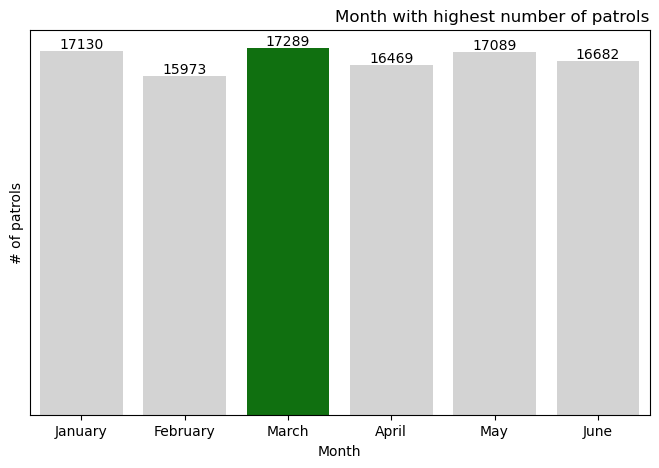

In [26]:
max_patrols = patrols_month['# of patrols'].max()
default_color = 'lightgray'
highlight_color = 'green'
colors = [highlight_color if val == max_patrols else default_color for val in patrols_month['# of patrols']]
plt.figure(figsize=(8,5))
ax = sns.barplot(patrols_month,x='Month',y='# of patrols',palette=colors)
for container in ax.containers:
    ax.bar_label(container)
plt.yticks([])
plt.title('Month with highest number of patrols',loc='right')
plt.show()

Monthly Patrol Volume
Highest number of patrols occurred in March  (17,289), followed closely by January and May.


#### Patrols by site

In [27]:
patrols = (df_patrols_cleaned
           .groupby(['Site'])['Timestamp']
           .count()
           .sort_values(ascending=False)
           .reset_index(name='# of patrols')
          )

/var/folders/4z/s5yytqj535948_tn28lrcsr40000gn/T/ipykernel_46436/615087735.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(patrols,x='Site',y='# of patrols',palette=colors)


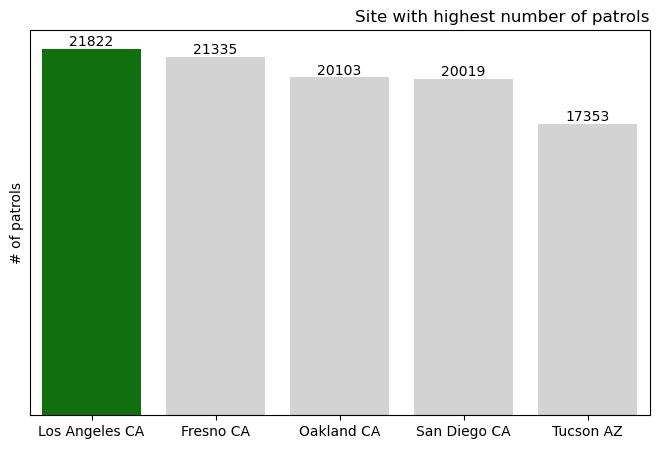

In [28]:
plt.figure(figsize=(8,5))
max_patrols = patrols['# of patrols'].max()
colors = [highlight_color if val==max_patrols else default_color for val in patrols['# of patrols']]
ax = sns.barplot(patrols,x='Site',y='# of patrols',palette=colors)
for container in ax.containers:
    ax.bar_label(container)
plt.yticks([])
plt.xlabel('')
plt.title('Site with highest number of patrols',loc='right')
plt.show()

Top Patrol Site
Los Angeles, CA recorded the highest number of patrols indicating it is either the most critical site or has the largest guard presence.


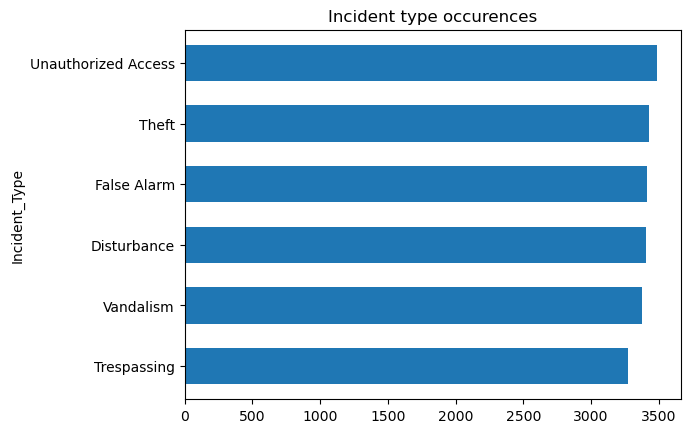

In [80]:
(df_patrols_cleaned
 .groupby('Incident_Type')['Timestamp']
 .count()
 .sort_values()
).plot(kind='barh', width=0.6)
plt.title('Incident type occurences')
plt.show()

Most common incident type is Unauthorised Access while the least common is Trespassing

In [29]:
def avg_guards_per_day():
    avg_per_day = {}
    locs = df_schedule['Site'].unique().tolist()
    
    for loc in locs:
        avg = (
            df_schedule[df_schedule['Site'] == loc]
            .groupby(['Date'])['Guard_ID']
            .count()
            .mean()
        )
        avg_per_day[loc] = avg
    
    return avg_per_day

/var/folders/4z/s5yytqj535948_tn28lrcsr40000gn/T/ipykernel_46436/3833741759.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(avg_guards_by_site,


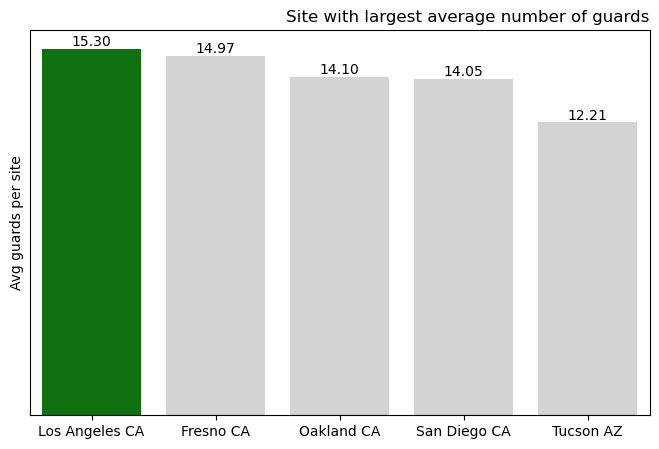

In [30]:
avg_guards_by_site = (pd.Series(avg_guards_per_day(), name='Avg guards per site')
                      .reset_index()
                      .rename(columns={'index':'Site'})
                      .sort_values(by='Avg guards per site',ascending=False)
                     )

max_guards = avg_guards_by_site['Avg guards per site'].max()

color = [highlight_color if val==max_guards else default_color for val in avg_guards_by_site['Avg guards per site']]

plt.figure(figsize=(8,5))
ax=sns.barplot(avg_guards_by_site,
             x='Site',
             y='Avg guards per site',
             palette=colors
            )
for container in ax.containers:
    ax.bar_label(container,fmt='%.2f')
plt.yticks([])
plt.xlabel('')
plt.title('Site with largest average number of guards', loc='right')
plt.show()

### Patrol Completion

In [31]:
# Percentage of patrols not completed by Interior/Exterior
percentage_not_completed = (
    df_patrols_cleaned
    .groupby('Interior_Exterior')['Patrol_Completed']
    .apply(lambda x: (~x).mean() * 100)
    .reset_index(name='% Not Completed')
)

In [32]:
percentage_not_completed

,Interior_Exterior,% Not Completed
0,Exterior,3.044439
1,Interior,2.978823


In [33]:
def get_patrol_noncompletion_rates(top_n=5, worst=True):
    """
    Returns the top N guards by percentage of patrols not completed.

    Parameters:
    top_n : int
        Number of top records to return.
    worst : bool
        If True, returns guards with the highest non-completion rates.
        If False, returns those with the lowest.

    Returns:
    pd.DataFrame
        A DataFrame with Guard_ID and their corresponding non-completion percentages.
    """
    non_completion_rate = (
        df_patrols_cleaned.groupby('Guard_ID')['Patrol_Completed']
        .apply(lambda x: (~x).mean() * 100)
        .sort_values(ascending=not worst)
        .reset_index()
        .rename(columns={'Patrol_Completed': 'Patrols Not Completed (%)'})
        .head(top_n)
    )

    return non_completion_rate

In [34]:
# 5 worst performing guards by completion of patrols
get_patrol_noncompletion_rates(5, True)

,Guard_ID,Patrols Not Completed (%)
0,1052,4.146577
1,1008,4.089980
2,1005,4.075829
3,1038,4.062500
4,1017,4.041451


Guard 1052 missed 4.15% of assigned patrols

In [35]:
# 5 best performing guards by completion of patrols
get_patrol_noncompletion_rates(5, False)

,Guard_ID,Patrols Not Completed (%)
0,1023,1.541624
1,1075,2.008032
2,1087,2.102377
3,1071,2.154750
4,1044,2.176063


Guard 1023 had only 1.54% missed patrols

### Response Time

In [36]:
incident_types = df_patrols_cleaned['Incident_Type'].dropna().unique().tolist()

df_incidents = df_patrols_cleaned[df_patrols_cleaned['Incident_Type'].isin(incident_types)]

In [37]:
def guard_response_time(top_n, best=True):    
    avg_response_time = (df_incidents
                         .groupby(['Guard_ID'])['Response_Time_Minutes']
                         .mean()
                         .reset_index()
                         .rename(columns={'Response_Time_Minutes':'Average_Response_Time_Minutes'})
                         .sort_values(by='Average_Response_Time_Minutes',ascending=best)
                         .head(top_n)
                        )
    return avg_response_time

In [38]:
# Top 5 guards by response time
guard_response_time(5, True)

,Guard_ID,Average_Response_Time_Minutes
61,1061,11.375269
46,1046,11.396635
35,1035,11.460096
85,1085,11.473232
18,1018,11.476768


In [39]:
# Bottom 5 guards by response time
guard_response_time(5, False)

,Guard_ID,Average_Response_Time_Minutes
12,1012,13.049321
34,1034,12.969519
38,1038,12.836607
63,1063,12.607767
90,1090,12.584581


Guards 1061, 1046, 1035, 1085 and 1018 all have average response times under 11.5 minutes. Guards 1012, 1034, 1038, 1063 and 1090 have the five worst response times all over 12.5 minutes.

In [40]:
# Average response time for incident types
response_by_incident_type = (df_incidents
 .groupby('Incident_Type')['Response_Time_Minutes']
 .mean()
 .reset_index(name='Avg Response_Time_Minutes')
 .sort_values(by='Avg Response_Time_Minutes',ascending=False)
)

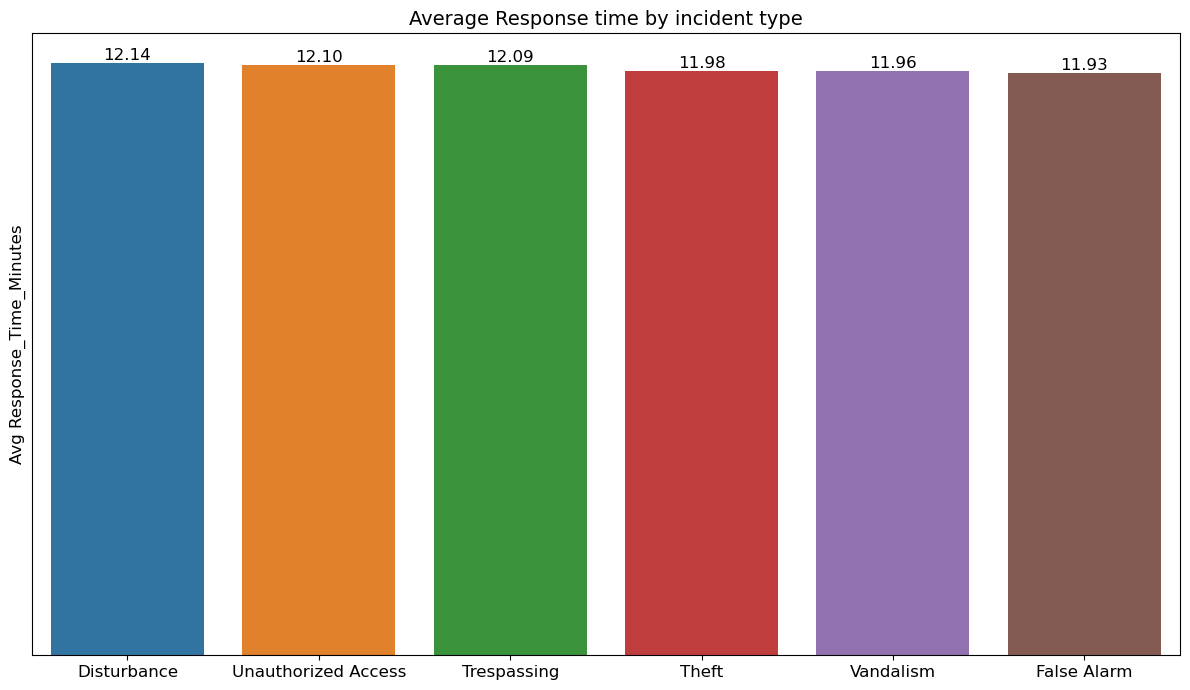

In [41]:
plt.figure(figsize=(12,7))
ax = sns.barplot(response_by_incident_type, 
                 x='Incident_Type',
                 y='Avg Response_Time_Minutes',
                 hue='Incident_Type')
for container in ax.containers:
    ax.bar_label(container,fmt='%.2f',fontsize=12)
plt.yticks([])
plt.xticks(fontsize=12)
plt.title('Average Response time by incident type',fontsize=14)
plt.xlabel('')
plt.ylabel('Avg Response_Time_Minutes',fontsize=12)
plt.tight_layout()
plt.show()

False Alarms had shorter average response times
Disturbance, Unauthorized Access and Trespassing had longer ones (\~12 min+)


In [42]:
response_by_int_ext = (df_incidents
           .groupby(['Interior_Exterior'])['Response_Time_Minutes']
           .mean()
           .reset_index(name='Avg Response_Time_Minutes')
           .sort_values(by='Avg Response_Time_Minutes',ascending=False)
          )

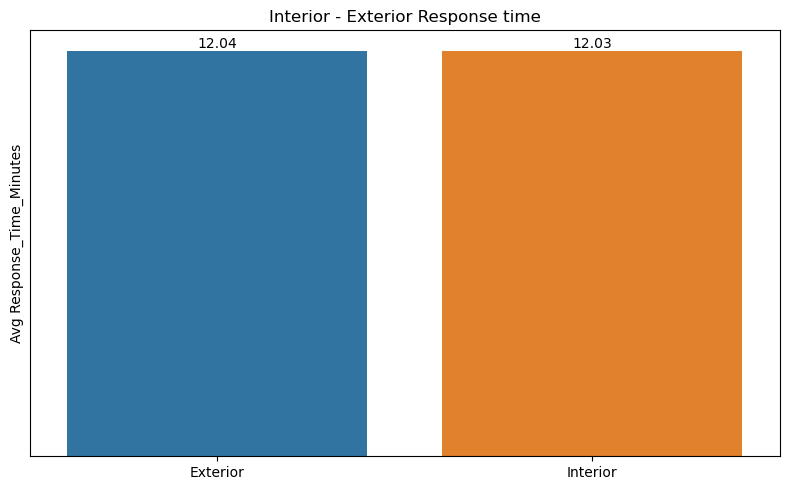

In [43]:
plt.figure(figsize=(8,5))
ax = sns.barplot(response_by_int_ext, 
                 x='Interior_Exterior',
                 y='Avg Response_Time_Minutes',
                 hue='Interior_Exterior'
                 )
for container in ax.containers:
    ax.bar_label(container,fmt='%.2f')
plt.yticks([])
plt.ylabel('Avg Response_Time_Minutes',fontsize=10)
plt.title('Interior - Exterior Response time',fontsize=12)
plt.xlabel('')
plt.tight_layout()
plt.show()

While both are relatively low, more the incidents in the interior are responded to faster.

In [44]:
# Average response time by shift
response_by_shift = (df_incidents
 .groupby('Shift')['Response_Time_Minutes']
 .mean()
 .reset_index(name='Avg Response_Time_Minutes')
 .sort_values(by='Avg Response_Time_Minutes',ascending=False)
)

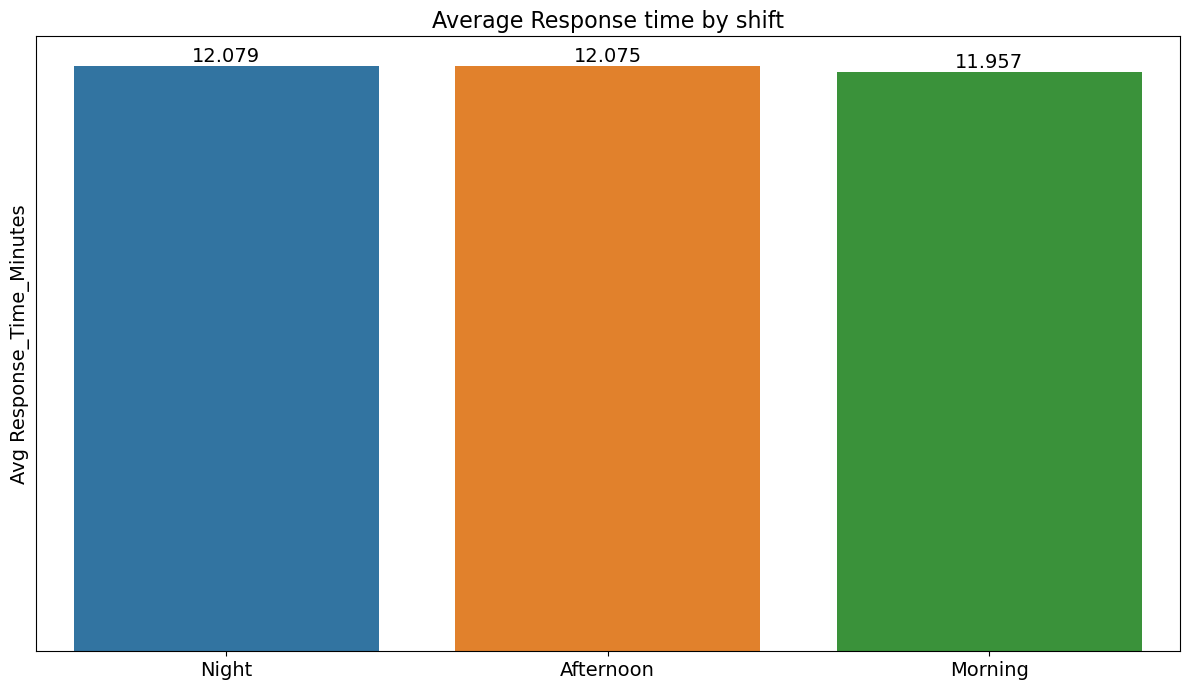

In [45]:
plt.figure(figsize=(12,7))
ax = sns.barplot(response_by_shift, 
                 x='Shift',
                 y='Avg Response_Time_Minutes',
                 hue='Shift')
for container in ax.containers:
    ax.bar_label(container,fmt='%.3f',fontsize=14)
plt.yticks([])
plt.xticks(fontsize=14)
plt.title('Average Response time by shift',fontsize=16)
plt.xlabel('')
plt.ylabel('Avg Response_Time_Minutes',fontsize=14)
plt.tight_layout()
plt.show()

Fastest responses occurred during Morning, slowest during Night

### QR Location scans

In [46]:
# Copy the DataFrame to avoid altering the original
df_qr_exploded = df_patrols_cleaned.copy()

# Split the locations into lists
df_qr_exploded['QR_Location'] = df_qr_exploded['QR_Code_Locations_Scanned'].str.split(',')

# Strip extra spaces
df_qr_exploded['QR_Location'] = df_qr_exploded['QR_Location'].apply(lambda locs: [loc.strip() for loc in locs])

# Step 4: Explode into multiple rows (one location per row)
df_qr_exploded = df_qr_exploded.explode('QR_Location').reset_index(drop=True)

In [47]:
df_qr_exploded.head(6)

,Timestamp,Site,Guard_ID,Shift,Interior_Exterior,Incident_Type,Response_Time_Minutes,Patrol_Completed,QR_Scans,QR_Code_Locations_Scanned,Overtime_Hours,Week,Month,Day,QR_Location
0,2024-01-01 22:13:37.155536510,Oakland CA,1000,Night,Interior,False Alarm,9.4,True,4,"Control Room, Lobby, Storage, Server Room",9.1,1,January,Monday,Control Room
1,2024-01-01 22:13:37.155536510,Oakland CA,1000,Night,Interior,False Alarm,9.4,True,4,"Control Room, Lobby, Storage, Server Room",9.1,1,January,Monday,Lobby
2,2024-01-01 22:13:37.155536510,Oakland CA,1000,Night,Interior,False Alarm,9.4,True,4,"Control Room, Lobby, Storage, Server Room",9.1,1,January,Monday,Storage
3,2024-01-01 22:13:37.155536510,Oakland CA,1000,Night,Interior,False Alarm,9.4,True,4,"Control Room, Lobby, Storage, Server Room",9.1,1,January,Monday,Server Room
4,2024-01-01 23:40:00.311344480,Oakland CA,1000,Night,Exterior,NaN,0.0,True,4,"Fence Line, Parking Lot, Gate A, Loading Dock",9.1,1,January,Monday,Fence Line
5,2024-01-01 23:40:00.311344480,Oakland CA,1000,Night,Exterior,NaN,0.0,True,4,"Fence Line, Parking Lot, Gate A, Loading Dock",9.1,1,January,Monday,Parking Lot


In [48]:
scans_by_location = (df_qr_exploded
 .groupby(['Interior_Exterior','QR_Location'])['Timestamp']
 .count()
 .sort_values(ascending=False)
 .reset_index()
 .rename(columns={'Timestamp':'# of QR scans'})
)

In [49]:
scans_by_location

,Interior_Exterior,QR_Location,# of QR scans
0,Interior,Control Room,30985
1,Interior,Server Room,30930
2,Interior,Lobby,30849
3,Interior,Storage,30846
4,Interior,Office Hallway,30738
5,Exterior,Gate B,29633
6,Exterior,Fence Line,29605
7,Exterior,Gate A,29599
8,Exterior,Loading Dock,29563
9,Exterior,Parking Lot,29445


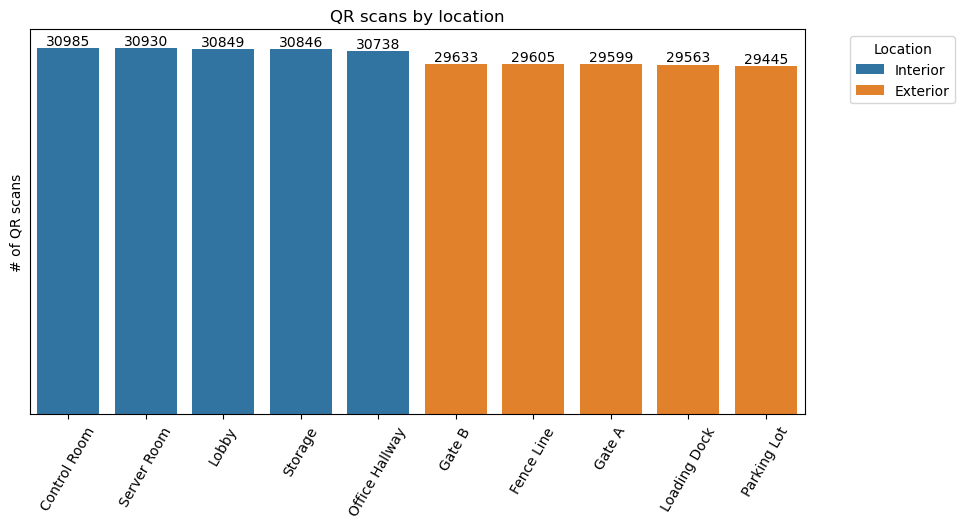

In [50]:
plt.figure(figsize=(10,5))
ax = sns.barplot(scans_by_location,
           x='QR_Location',
           y='# of QR scans',
           hue='Interior_Exterior'     
                )
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(rotation=60)
plt.yticks([])
plt.title('QR scans by location')
plt.xlabel('')
plt.legend(title='Location',bbox_to_anchor=(1.05,1),loc='upper left')
plt.show()

Interior: Control Room, Server Room, Lobby
Exterior: Gate B, Fence Line, Gate A

The interior QR scans are scanned more. 

This suggests guards are consistently checking key access points and surveillance areas. 

#### Incidents by QR location and shift

In [51]:
df_incidents_exploded = df_incidents.copy()
df_incidents_exploded['QR_Location'] = df_incidents_exploded['QR_Code_Locations_Scanned'].str.split(',') 
df_incidents_exploded['QR_Location'] = (df_incidents_exploded['QR_Location']
                                         .apply(lambda locs: [loc.strip() for loc in locs]))
df_incidents_exploded = df_incidents_exploded.explode('QR_Location')

In [52]:
df_incidents_exploded.head()

,Timestamp,Site,Guard_ID,Shift,Interior_Exterior,Incident_Type,Response_Time_Minutes,Patrol_Completed,QR_Scans,QR_Code_Locations_Scanned,Overtime_Hours,Week,Month,Day,QR_Location
0,2024-01-01 22:13:37.155536510,Oakland CA,1000,Night,Interior,False Alarm,9.4,True,4,"Control Room, Lobby, Storage, Server Room",9.1,1,January,Monday,Control Room
0,2024-01-01 22:13:37.155536510,Oakland CA,1000,Night,Interior,False Alarm,9.4,True,4,"Control Room, Lobby, Storage, Server Room",9.1,1,January,Monday,Lobby
0,2024-01-01 22:13:37.155536510,Oakland CA,1000,Night,Interior,False Alarm,9.4,True,4,"Control Room, Lobby, Storage, Server Room",9.1,1,January,Monday,Storage
0,2024-01-01 22:13:37.155536510,Oakland CA,1000,Night,Interior,False Alarm,9.4,True,4,"Control Room, Lobby, Storage, Server Room",9.1,1,January,Monday,Server Room
7,2024-01-02 05:30:02.587330264,Oakland CA,1000,Night,Exterior,Unauthorized Access,10.7,True,2,"Loading Dock, Gate A",9.1,1,January,Tuesday,Loading Dock


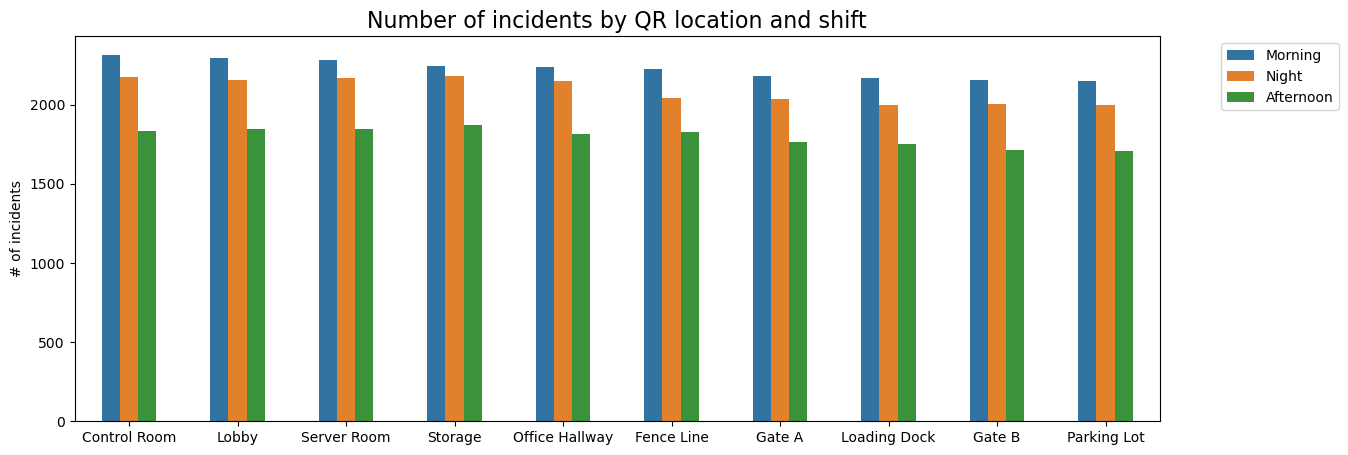

In [53]:
incidents_by_shift_and_location = (df_incidents_exploded
 .groupby(['QR_Location','Shift'])['Incident_Type']
 .count()
 .reset_index(name='# of incidents')
 .sort_values(by='# of incidents', ascending=False)
)
plt.figure(figsize=(14,5))
sns.barplot(incidents_by_shift_and_location,
            x='QR_Location',
            y='# of incidents',
            hue='Shift',
            width=0.5
           )
plt.legend(bbox_to_anchor=(1.05,1))
plt.title('Number of incidents by QR location and shift', fontsize=16)
plt.xlabel('')
plt.show()

While the difference in number of incidents in the QR locations is small, the chart shows that Control Room has the highest number of incidents. It also shows incidents are most frequent during the Morning shift

In [71]:
def qr_loc_incidents(qr_loc):
    incidents = df_incidents_exploded[
        df_incidents_exploded['QR_Location'] == qr_loc]
    
    incident_counts = (incidents
                       .groupby('Incident_Type')['Timestamp']
                       .count()
                       .reset_index(name='# of incidents')
                       .sort_values(by='# of incidents',ascending=False)
                      )

    plt.figure(figsize=(5,5))
    ax = sns.barplot(data=incident_counts, x='Incident_Type', y='# of incidents')
    for container in ax.containers:
        ax.bar_label(container)
    plt.title(f'Number of Incidents at {qr_loc}')
    plt.xlabel('')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

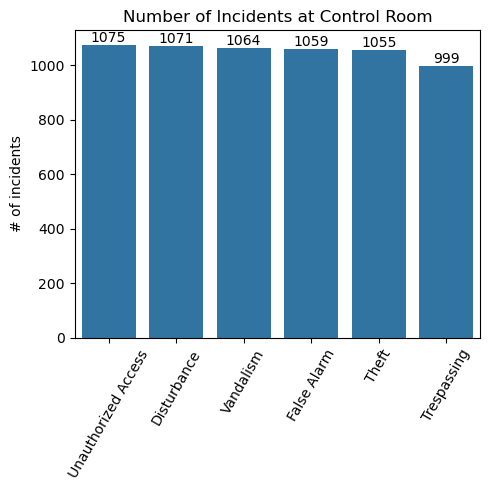

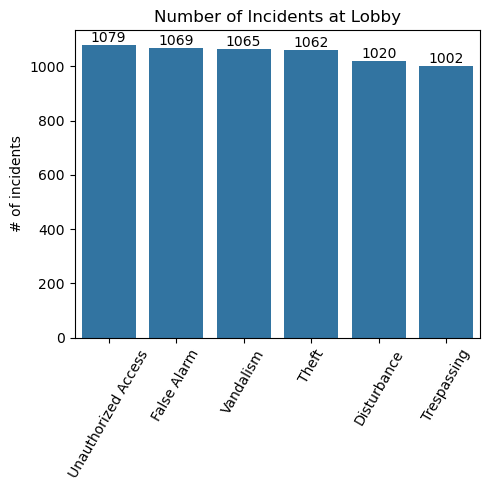

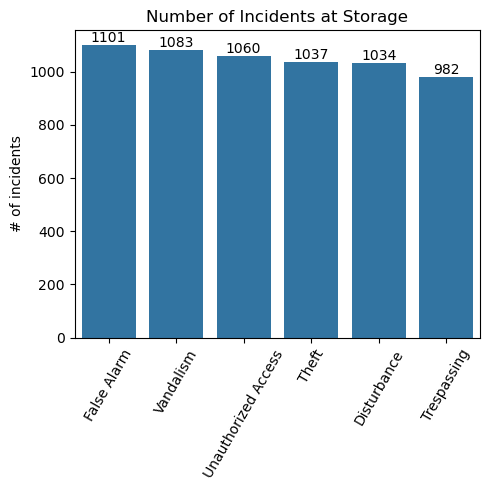

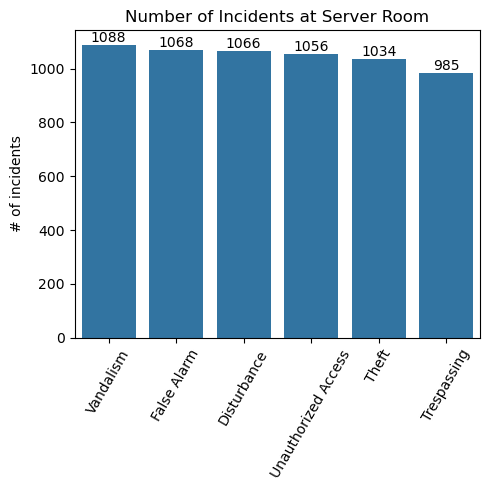

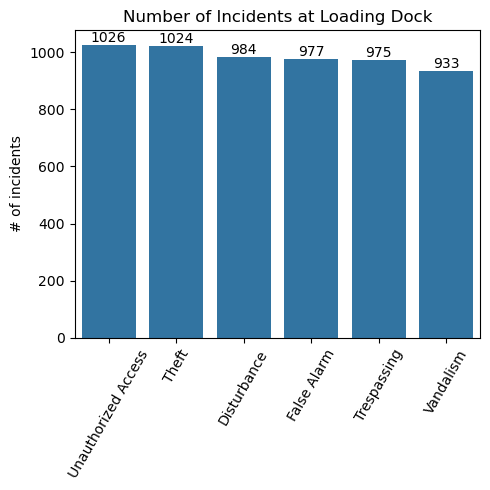

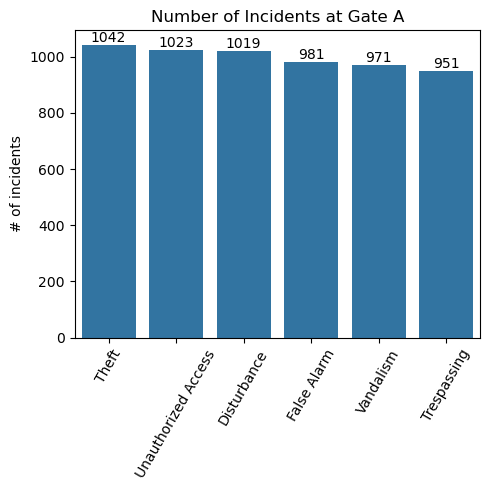

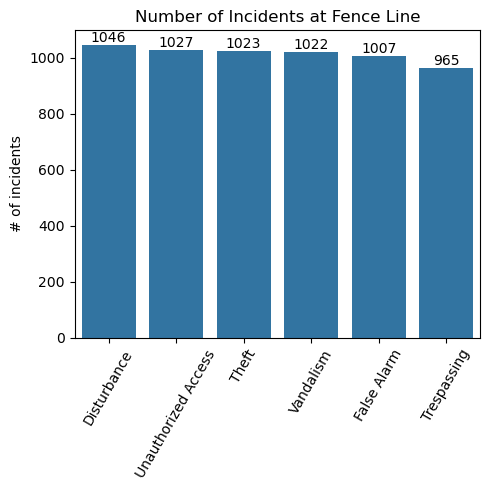

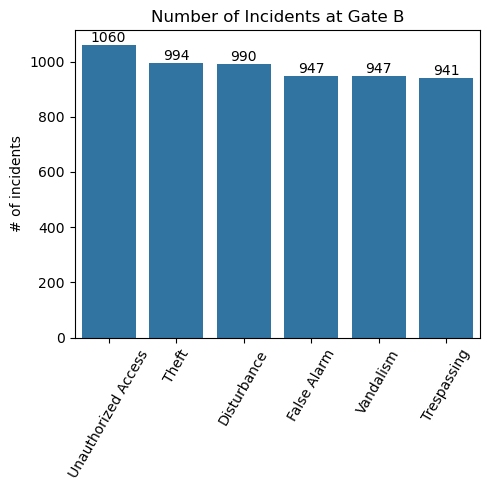

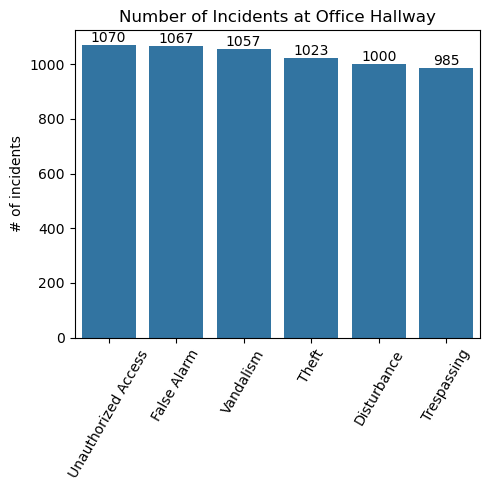

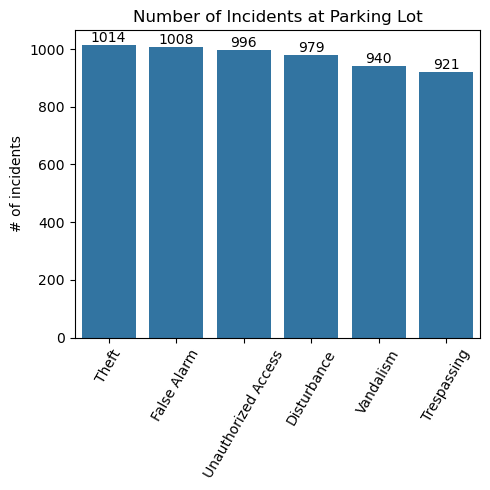

In [72]:
for loc in df_incidents_exploded['QR_Location'].unique().tolist():
    qr_loc_incidents(loc)    

In [57]:
# Get average response time for the different QR locations
response_qr_location = (df_incidents_exploded
 .groupby(['QR_Location'])['Response_Time_Minutes']
 .mean()
 .sort_values(ascending=False)
 .reset_index(name='Avg_Response_Time_Minutes')
)

In [58]:
response_qr_location.head()

,QR_Location,Avg_Response_Time_Minutes
0,Control Room,12.075233
1,Parking Lot,12.072089
2,Gate B,12.050315
3,Office Hallway,12.043808
4,Gate A,12.028712


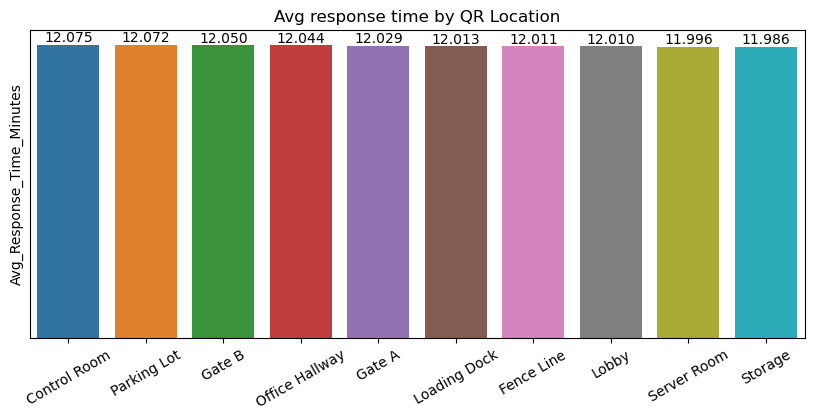

In [59]:
plt.figure(figsize=(10,4))
ax = sns.barplot(response_qr_location,
                 x='QR_Location',
                 y='Avg_Response_Time_Minutes',
                 hue='QR_Location'
                )
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f')
plt.xticks(rotation=30)
plt.yticks([])
plt.title('Avg response time by QR Location')
plt.xlabel('')
plt.show()

The differences in response time are really small but in situations where every second matter, these differences are significant.
False Alarms had shorter average response times
Disturbance, Unauthorized Access and Trespassing had longer ones (~12 min+)


### Shifts

In [60]:
overtime_by_guard = (df_patrols_cleaned
 .groupby(['Guard_ID','Shift'])['Overtime_Hours']
 .sum()
 .reset_index(name='# of overtime_hours')
)

In [61]:
overtime_by_shift = (overtime_by_guard
 .groupby('Shift')['# of overtime_hours']
 .sum() 
 .reset_index()
 .sort_values(by='# of overtime_hours',ascending=False)
)

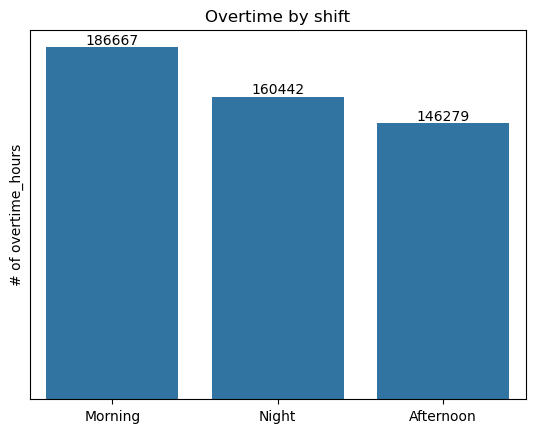

In [62]:
ax = sns.barplot(overtime_by_shift,
            x='Shift',
            y='# of overtime_hours'
           )
for container in ax.containers:
    ax.bar_label(container)
plt.yticks([])
plt.xlabel('')
plt.title('Overtime by shift')
plt.show()

The morning shift accounts for the majority of overtime hours which suggest possible understaffing or scheduling inefficiencies in that shift.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


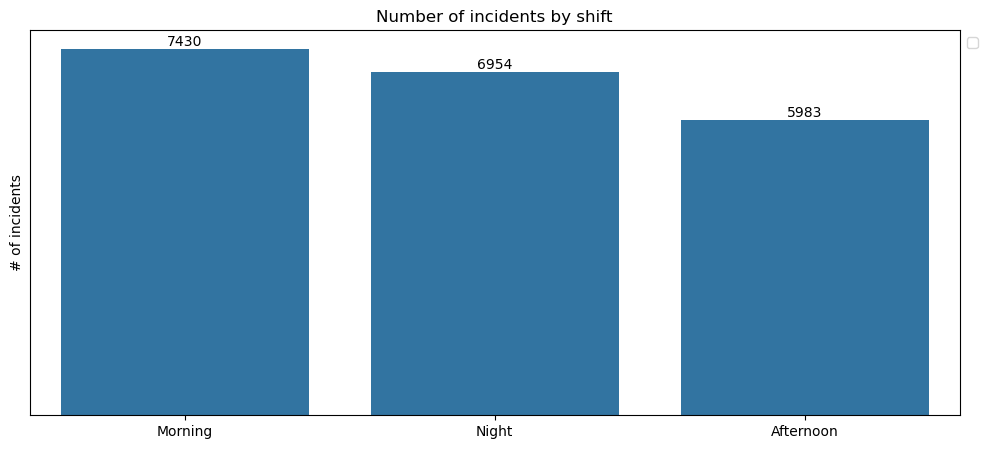

In [63]:
incidents_and_shifts = (df_incidents
           .groupby(['Shift'])['Timestamp']
           .count()
           .reset_index(name='# of incidents')
           .sort_values(by='# of incidents',ascending=False)
          )

plt.figure(figsize=(12,5))
ax = sns.barplot(incidents_and_shifts,
            x='Shift',
            y='# of incidents',
           )
for container in ax.containers:
    ax.bar_label(container)
plt.yticks([])
plt.xlabel('')
plt.legend(bbox_to_anchor=(1,1),loc='upper left')
plt.title('Number of incidents by shift')
plt.show()

In [64]:
incidents_by_shift = (df_incidents
           .groupby(['Incident_Type','Shift'])['Timestamp']
           .count()
           .reset_index(name='# of incidents')
           .sort_values(by='# of incidents',ascending=False)
          )

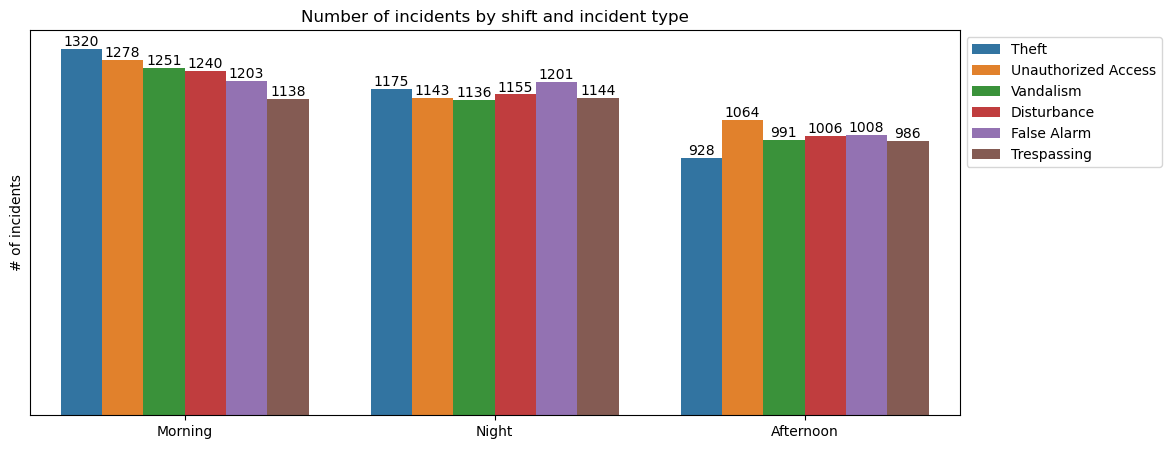

In [65]:
plt.figure(figsize=(12,5))
ax = sns.barplot(incidents_by_shift,
            x='Shift',
            y='# of incidents',
            hue='Incident_Type'
           )
for container in ax.containers:
    ax.bar_label(container)
plt.yticks([])
plt.xlabel('')
plt.legend(bbox_to_anchor=(1,1),loc='upper left')
plt.title('Number of incidents by shift and incident type')
plt.show()

The Morning shift has the highest number of incidents with theft being the most prevalent incident.

Next is the Night shift. The most prevalent incident for this shift is False alarms.

The Afternoon shift has the fewest incidents. Unauthorised access is the most common incident during this shift.

## Key Insights

### 1. Guard Attendance & Punctuality

* **Chronic lateness was observed across shifts**, with:

  * **Guard 1001** arriving late **17 times** during morning shifts.
  * **Guard 1091** was late **16 times** for night shifts.
  * **Several guards** recorded **10+ late arrivals** across shifts.
* **Shift coverage** revealed:

  * **Guards 1026 and 1057** frequently covered others, with **31 cover shifts each**, suggesting a few guards are heavily relied upon.

### 2. **Patrol Completion & Guard Performance**

* Average **patrol completion rate** is high, but:

  * **Guard 1052 missed 4.15%** of patrols — the worst among all guards.
  * **Top performers** like **Guard 1023** missed only **1.54%** of patrols.
* **Exterior patrols** are **slightly more likely to be missed** (3.04%) than interior ones (2.97%).

### 3. **Incident Trends**

* **Unauthorized access** is the most common incident, followed by disturbances.
* **Incidents peak during the morning shift**, especially **theft**, indicating higher vulnerability.
* **Control Room** is the most incident-prone QR location.

### 4. **Response Time Analysis**

* Best average responders:

  * **Guard 1061**: 11.37 minutes.
* Worst average responders:

  * **Guard 1012**: 13.05 minutes.
* **Interior incidents** received faster response than **exterior incidents**.
* **Morning shift** had the **fastest** average response time, while **night shift** was the **slowest**.

### 5. **Site-Level Insights**

* **Los Angeles, CA** had the **highest number of patrols**, suggesting either larger area coverage or higher security concern.
* **March** had the **most patrol activity**, with data in **July** dropped due to insufficient volume.
* Sites like **Oakland** had high scan activity at **Control Room, Lobby, and Server Room**.

### 6. **QR Location Scan Analysis**

* **Control Room, Server Room, and Lobby** are the top scanned interior QR points.
* **Gate B, Fence Line, and Gate A** are most scanned in exterior areas.
* Suggests guards are prioritizing **access control and surveillance zones** effectively.

### 7. **Overtime & Scheduling**

* **Morning shift has the highest overtime burden**, signaling potential understaffing.
* Shift-based incident and overtime correlation suggests **staffing inefficiencies during high-risk periods**.

---

##  **Recommendations**

### 1. **Improve Shift Punctuality**

* **Implement biometric clock-ins** with alerts for late check-ins.
* **Provide feedback/coaching** for persistently late guards.
* Consider **automated shift reminders** or re-evaluating start times based on traffic or fatigue patterns.

### 2. **Balance Workload & Shift Coverage**

* Avoid **over-reliance on a few guards** (e.g., 1026, 1057) for covering shifts.
* Distribute coverage responsibilities more evenly to **reduce burnout**.
* Review shift assignments for guards with **high non-completion and lateness records**.

### 3. **Patrol Completion & Accountability**

* Install **real-time patrol monitoring systems** to track uncompleted routes.
* Set **completion thresholds** and alerts for patrols under 95% to ensure compliance.

### 4. **Response Time Optimization**

* Use **incident heatmaps and response logs** to better staff high-incident zones.
* Introduce **response-time SLAs** and reward high-performing guards (like Guard 1061).
* **Cross-train guards** to handle a wider range of incidents, especially in high-incident areas like Control Room.

### 5. **Incident Management Enhancements**

* Increase **morning shift staffing** or implement **surprise audits** during this high-incident period.
* Fortify **vulnerable areas** such as **Control Room and Server Room** with additional surveillance or static guards.
* Prioritize **training around theft and unauthorized access** scenarios.

### 6. **Site-Specific Strategy**

* Evaluate **why Los Angeles and Oakland** have higher patrol volumes and incidents — could be due to **site complexity, layout, or known threats**.
* Reassess **QR scan distributions** to ensure **even patrol coverage** across all areas.

### 7. **Tackle Overtime Inefficiencies**

* **Audit morning shift schedules** to determine cause of overtime (e.g., shift overrun, late check-in, site size).
* Introduce **rotating breaks** or shorter shifts in high-overtime periods to avoid fatigue.

